In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys

import cv2
import numpy as np
from PIL import Image

from matting_api import Matting

sys.path.append('..')
import utils
import inference as infer
from datasets import KINSLVISDataset
from demo_utils import *

font = {'family' : 'sans-serif',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
# functions

def bkg_inpaint(inpaintnet, image, input_size, modal, ex_ind, dilate, bbox=None):
    modal_bkg = (sum([modal[e] for e in ex_ind]) == 0).astype(np.uint8)
    amodal_bkg = np.ones(image.shape[:2], dtype=np.uint8)
    need_recover = False
    if bbox is None:
        need_recover = True
        bbox = get_square_bbox(*image.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(image, bbox, pad_value=(0,0,0)), (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    modal_patch = infer.resize_mask(
        utils.crop_padding(modal_bkg, bbox, pad_value=(0,)), input_size, 'linear')
    amodal_patch = infer.resize_mask(
        utils.crop_padding(amodal_bkg, bbox, pad_value=(0,)), input_size, 'linear')
    ret, rgb_erased, vsb_mask = inpaintnet.inference(
        rgb, modal_patch, 1, amodal_patch, dilate=dilate, with_modal=False)
    if need_recover:
        ret = recover_image_patch(ret, bbox, image.shape[0], image.shape[1], (255,255,255), interp='cubic')
        vsb_mask = infer.recover_mask(vsb_mask, bbox, image.shape[0], image.shape[1], 'linear')
    return ret, vsb_mask

def content_completion(pcnetc, image, input_size, modal, bboxes, amodal_patches_pred, category, idx, dilate, debug=False):
    rgb = cv2.resize(
        utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)),
        (input_size, input_size), interpolation=cv2.INTER_CUBIC)
    modal_patch = infer.resize_mask(
       utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), input_size, 'linear')
    amodal_patch = infer.resize_mask(
        amodal_patches_pred[idx], input_size, 'linear')
    ret, rgb_erased, vsb_mask = pcnetc.inference(
        rgb, modal_patch, category[idx].item(), amodal_patch, dilate=dilate)
    ret = recover_image_patch(ret, bboxes[idx], image.shape[0], image.shape[1], (255,255,255))
    vsb_mask = infer.recover_mask(vsb_mask, bboxes[idx], image.shape[0], image.shape[1], 'linear')
    return ret, vsb_mask

In [3]:
# dataset
phase = 'train'
root_dict = {'train': "/ext/hoya/deocclusion/data/KINS/training/image_2", 'val': '/ext/hoya/deocclusion/data/KINS/testing/image_2'}

img_root = root_dict[phase]
annot_path = "/ext/hoya/deocclusion/data/KINS/instances_{}.json".format(phase)

data_reader = KINSLVISDataset('KINS', annot_path)

In [7]:
# PCNet-M
#exp = '../experiments/KINS/pcnet_m'

config_file = '/deocclusion/experiments/KINS/pcnet_m/config.yaml'
load_model = '/ext/hoya/deocclusion/kins_model/KINS_pcnet_m.pth.tar'

pcnetm = DemoPCNetM(config_file, load_model)
#LOADER 에러 뜰 시, demo_utils.py 수정
#import yaml 

#with open('config.yaml', 'r') as f:
#    config = yaml.load(f, Loader=yaml.SafeLoader)

/deocclusion/experiments/KINS/pcnet_m/config.yaml
=> loading checkpoint '/ext/hoya/deocclusion/kins_model/KINS_pcnet_m.pth.tar'


In [8]:
# Matting
# Please download the pretrained model from: https://github.com/Yaoyi-Li/GCA-Matting/blob/master/README.md에서 pth 파일 다운
matting_model = Matting(
    '/deocclusion/demos/GCAMatting/config/gca-dist-all-data.toml',
    '/deocclusion/demos/GCAMatting/checkpoints/gca-dist-all-data/gca-dist-all-data.pth')

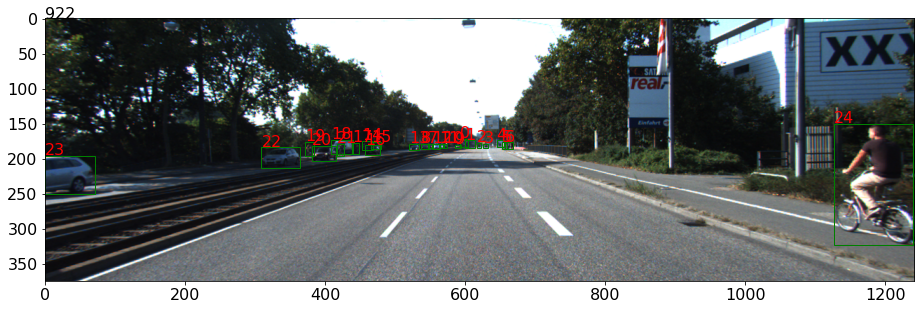

In [58]:
# get an image
img_idx = 922
#img_idx = np.random.choice(len(data_reader.img_ids)) # randomly choose an image
modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(img_idx, with_gt=True)
img_path = os.path.join(img_root, image_fn)
img = Image.open(img_path)
image = np.array(img)
height, width = img.height, img.width
plt.figure(figsize=(16, 16./width*height))
plt.imshow(img)
plt.text(0, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i), color='r')
plt.show()

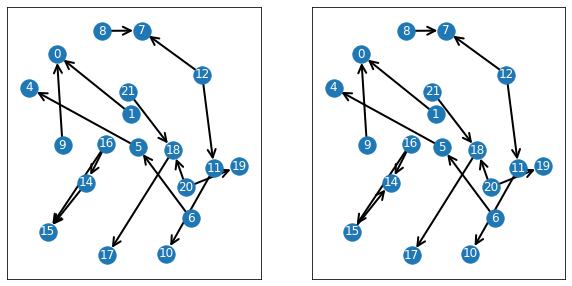

left: predicted ordering graph, right: ground truth ordering graph. Accuracy: 93.33


In [59]:
# infer ordering
gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)
bboxes = expand_bbox(ori_bboxes, enlarge_ratio=3., single_ratio=1.5)
order_matrix = infer.infer_order(
    pcnetm.model, image, modal, category, bboxes,
    use_rgb=pcnetm.use_rgb, th=0.1, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='nearest', debug_info=False)
allpair_true, allpair, occpair_true, occpair, show_err = infer.eval_order(order_matrix, gt_order_matrix)
acc_occpair = occpair_true / occpair
plt.figure(figsize=(10,5))
plt.subplot(121)
pos = draw_graph(order_matrix)
plt.subplot(122)
draw_graph(gt_order_matrix, pos=pos)
plt.show()
print('left: predicted ordering graph, right: ground truth ordering graph. Accuracy: {:.2f}'.format(acc_occpair * 100))

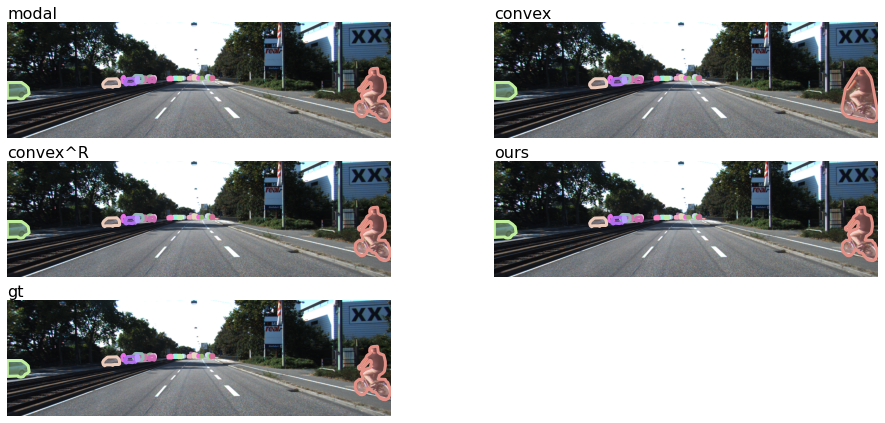

In [60]:
# amodal completion

# convex hull
order_matrix_cvx = infer.infer_order_hull(modal)
amodal_pred_cvx = np.array(infer.infer_amodal_hull(modal, bboxes, None, order_grounded=False))
amodal_pred_cvxr = np.array(infer.infer_amodal_hull(modal, bboxes, order_matrix_cvx, order_grounded=True))

# ours
amodal_patches_pred = infer.infer_amodal(
    pcnetm.model, image, modal, category, bboxes, order_matrix,
    use_rgb=pcnetm.use_rgb, th=0.4, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='linear', debug_info=False)
amodal_pred_ours = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp='linear')

# show amodal
exclude = []
rows = 3
cols = 2
bbox_show = [0, 0, 500, height]
bbox_show = None

selidx = np.array([i for i in np.arange(modal.shape[0]) if i not in exclude])
image_show = image[bbox_show[1]:bbox_show[3], bbox_show[0]:bbox_show[2], :] \
    if bbox_show is not None else image.copy()

if bbox_show is not None:
    plt.figure(figsize=(16, 16./(bbox_show[2]-bbox_show[0])*(bbox_show[3]-bbox_show[1]) * 3 / 2))
else:
    plt.figure(figsize=(16, 16./width*height * rows / cols))
    
toshow = [modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_ours, amodal_gt]
title = ['modal', 'convex', 'convex^R', 'ours', 'gt']

colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
for i in range(len(toshow)):
    plt.subplot(rows, cols, i + 1)
    ax = plt.gca()
    plt.imshow(image_show)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, bbox_show, thickness=3)
    ax.add_collection(pface)
    ax.add_collection(pedge)
# plt.savefig('outputs/amodal_display/kins_{}.jpg'.format(img_idx), dpi=72)
# cv2.imwrite("outputs/amodal_display/kins_{}_img.jpg".format(img_idx),
#             image_resize(image_sub[:,:,::-1], long_size=480))
plt.show()

In [61]:
toshow[3] #amodal mask

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [62]:
def mask_to_polygons(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        # Approximate contour to polygon
        epsilon = 0.01 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        
        # Convert to list of tuples
        polygon = [(point[0][0], point[0][1]) for point in polygon]
        
    
    return polygon

In [63]:
polygons =[]
for mask in toshow[3]:
    polygon = mask_to_polygons(mask)
    polygons.append(polygon)
    
#print(polygons)   
print(polygons)

[[(593, 172), (593, 179), (594, 180), (594, 182), (597, 182), (598, 181), (600, 181), (601, 180), (604, 180), (604, 176), (603, 175), (603, 173), (599, 173), (598, 172)], [(601, 175), (600, 177), (600, 179), (601, 180), (601, 183), (603, 184), (605, 181), (607, 181), (611, 184), (613, 183), (613, 180), (612, 179), (612, 175), (610, 174), (604, 174), (603, 175)], [(618, 178), (617, 179), (617, 183), (619, 183), (620, 184), (622, 184), (622, 181), (621, 180), (621, 179), (620, 178)], [(626, 180), (626, 184), (632, 184), (632, 182), (631, 181), (631, 179), (627, 179)], [(645, 176), (645, 181), (650, 181), (651, 182), (652, 181), (654, 181), (653, 180), (655, 177), (655, 175), (654, 174), (647, 174)], [(658, 177), (654, 177), (652, 179), (652, 184), (654, 186), (655, 186), (659, 182), (659, 179), (658, 178)], [(657, 180), (657, 183), (658, 184), (658, 185), (659, 185), (660, 186), (661, 186), (663, 184), (664, 184), (665, 185), (667, 185), (667, 178), (666, 177), (660, 177)], [(547, 179), 

In [64]:
order_matrix

array([[ 0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0, 

In [65]:
import numpy as np
from shapely.geometry import Polygon

def calculate_occlusion_ratio(depth_relations, polygons):
    num_objects = len(depth_relations)
    #print(num_objects)
    occlusion_ratios = np.zeros(num_objects)
    for i in range(num_objects):
        occluded_area = 0
        
        # Iterate over objects that are behind the current object
        for j in range(0, num_objects):
            #print(depth_relations[i][j])
            if depth_relations[i][j] == -1:
                # Calculate the occluded area using Shapely and Polygon
                #print(polygons)
                occluded_polygon = polygons[j]  # Assuming polygons are in [x, y] format
                occluded_area += Polygon(polygons[i]).intersection(Polygon(occluded_polygon)).area
                #print(occluded_area)
        # Calculate the occlusion ratio for the current object
        total_area = Polygon(polygons[i]).area
        occlusion_ratios[i] = occluded_area / total_area

    return occlusion_ratios

# Calculate occlusion ratios
occlusion_ratios = calculate_occlusion_ratio(order_matrix, polygons)

# Print occlusion ratios for each object
for i, ratio in enumerate(occlusion_ratios):
    print(f"Object {i} Occlusion Ratio: {ratio:.2%}")

Object 0 Occlusion Ratio: 20.11%
Object 1 Occlusion Ratio: 0.00%
Object 2 Occlusion Ratio: 0.00%
Object 3 Occlusion Ratio: 0.00%
Object 4 Occlusion Ratio: 8.59%
Object 5 Occlusion Ratio: 15.15%
Object 6 Occlusion Ratio: 0.00%
Object 7 Occlusion Ratio: 8.33%
Object 8 Occlusion Ratio: 0.00%
Object 9 Occlusion Ratio: 0.00%
Object 10 Occlusion Ratio: 11.82%
Object 11 Occlusion Ratio: 5.32%
Object 12 Occlusion Ratio: 0.00%
Object 13 Occlusion Ratio: 0.00%
Object 14 Occlusion Ratio: 15.35%
Object 15 Occlusion Ratio: 42.36%
Object 16 Occlusion Ratio: 0.00%
Object 17 Occlusion Ratio: 20.39%
Object 18 Occlusion Ratio: 22.26%
Object 19 Occlusion Ratio: 7.91%
Object 20 Occlusion Ratio: 0.00%
Object 21 Occlusion Ratio: 0.00%
Object 22 Occlusion Ratio: 0.00%
Object 23 Occlusion Ratio: 0.00%
Object 24 Occlusion Ratio: 0.00%


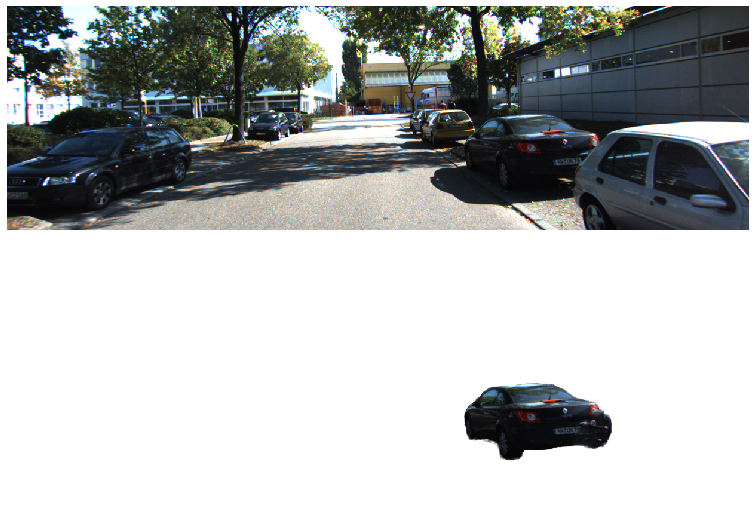

In [29]:
# content completion

show_idx = 14 # set to -1 to show the background

fg_idx = list(range(modal.shape[0]))
input_size = 256
input_size_bkg = 384
fg_dilate = int(float(input_size) / 256 * 5)
bg_dilate = int(float(input_size_bkg) / 256 * 3)

# for objects
rgb_decomps = []
mask_decomps = []
compose = lambda image, alpha: np.concatenate([image, alpha[:,:,np.newaxis]], axis=2)
for i in fg_idx:
    ret, vsb_mask = content_completion(pcnetc, image, input_size, modal, bboxes, amodal_patches_pred, category, i, fg_dilate, False)
    trimap = gettrimap(amodal_pred_ours[i], 3)
    alpha = matting_model.inference(ret, trimap)
    ret = compose(ret, alpha)
    rgb_decomps.append(ret)

# background inpainting
bkg, vsb_mask = bkg_inpaint(inpaintnet, image, input_size_bkg, modal, fg_idx, bg_dilate)

for c in range(3):
    bkg[:,:,c][vsb_mask == 1] = image[:,:,c][vsb_mask == 1]

# show
plt.figure(figsize=(15, 30./img.width*img.height))
ax = plt.subplot(211)
plt.imshow(image)
plt.axis('off')
plt.subplot(212)
if show_idx == -1:
    plt.imshow(bkg)
else:
    this_obj = rgb_decomps[fg_idx.index(show_idx)]
    plt.imshow(this_obj)
plt.axis('off')
plt.show()

# save
if False:
    sort_ind = topological_sort(order_matrix)
    if not os.path.isdir('outputs/decomposition/image_{:04d}'.format(img_idx)):
        os.makedirs('outputs/decomposition/image_{:04d}'.format(img_idx))
    cv2.imwrite('outputs/decomposition/image_{:04d}.png'.format(img_idx), image[:,:,::-1])
    for i in sort_ind:
        obj = rgb_decomps[i]
        rgb = obj[:,:,:3]
        alpha = obj[:,:,3:]
        cv2.imwrite('outputs/decomposition/image_{:04d}/obj_{:03d}.png'.format(
            img_idx, i), np.concatenate([rgb[:,:,::-1], alpha], axis=2))
    cv2.imwrite('outputs/decomposition/image_{:04d}/bkg.png'.format(img_idx), bkg[:,:,::-1])

In [68]:
#AIMMO FORMAT -> MASK 예제

def points_to_polygon(points):
    """
    Convert point-based segmentation to polygon-based segmentation.

    Parameters:
    - points (list of lists): List of [x, y] points representing the segmentation.

    Returns:
    - list of lists: List of [x, y] points representing the corresponding polygon.
    """
    # Ensure that the list of points is not empty
    if not points:
        return []

    # Duplicate the first point at the end to ensure a closed polygon
    points.append(points[0])

    # Convert the list of points to the polygon format
    polygon = []
    for point in points:
        polygon.append(int(point[0]))
        polygon.append(int(point[1]))

    return polygon

# Example usage:
point_segmentation =[
        [
          1490,
          1434
        ],
        [
          1504,
          1436
        ],
        [
          1511,
          1435
        ],
        [
          1509,
          1429
        ],
        [
          1509,
          1419
        ],
        [
          1516,
          1404
        ],
        [
          1525,
          1396
        ],
        [
          1535,
          1392
        ],
        [
          1526,
          1391
        ],
        [
          1521,
          1392
        ],
        [
          1519,
          1394
        ],
        [
          1504,
          1395
        ],
        [
          1493,
          1407
        ],
        [
          1489,
          1422
        ],
        [
          1489,
          1428
        ]
      ]
polygon_segmentation = points_to_polygon(point_segmentation)
print(polygon_segmentation)

[1490, 1434, 1504, 1436, 1511, 1435, 1509, 1429, 1509, 1419, 1516, 1404, 1525, 1396, 1535, 1392, 1526, 1391, 1521, 1392, 1519, 1394, 1504, 1395, 1493, 1407, 1489, 1422, 1489, 1428, 1490, 1434]


In [69]:
import pycocotools.mask as maskUtils

rles = maskUtils.frPyObjects([polygon_segmentation], 2168, 3840)

rle = maskUtils.merge(rles)
print(rle)

{'size': [2168, 3840], 'counts': b'TlaR3;YS27J3L4M3O2N1O1O1O1O1O1O2N1N20000000O100_OlmM^OTR2`0QnM]OnQ2b0e0M3N2N2N2N200O00001O1O001O100O10000O101N1000Pl`h4'}
